In [32]:
import os
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import anndata as ad
import scanpy as sc
import seaborn as sns
from fs import open_fs
from matplotlib_scalebar.scalebar import ScaleBar
from tqdm import tqdm
from skimage.measure import block_reduce
import tifffile
import string

mpl.rcParams.update(mpl.rcParamsDefault) #Reset rcParams to default
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  # Colors in this style

# Plotting style function (run this before plotting the final figure)
def set_plotting_style():
    plt.style.use('seaborn-paper')
    plt.rc('axes', labelsize=12)
    plt.rc('axes', titlesize=12)
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)
    plt.rc('legend', fontsize=10)
    plt.rc('text.latex', preamble=r'\usepackage{sfmath}')
    plt.rc('xtick.major', pad=2)
    plt.rc('ytick.major', pad=2)
    plt.rc('mathtext', fontset='stixsans', sf='sansserif')
    plt.rc('figure', figsize=[10,9])
    plt.rc('svg', fonttype='none')
    
# Function to preprocess raw AnnData object

def preprocess_ad(ad, min_counts):
    ad.layers['counts'] = ad.X.copy()
    sc.pp.filter_cells(ad, min_counts=min_counts)
    sc.pp.normalize_total(ad, target_sum=1e4) # Normalize data
    sc.pp.log1p(ad) # Logarithmize the data
    #sc.pp.scale(ad) # Scale each gene to unit variance

In [33]:
# Load postprocessed MERFISH and MACA results

# Define the path of the analyzed MERFISH data
dataPathPost = '/mnt/ibm_lg/spatial-seq/MERlin_Analysis/ProcessedResults'

# Define the experiments
experimentName = ['MsLiver_Cellbound_VZG116_V1_JH_09-18-2021', 
                  'MsKidney_CellBoundary_VZG116_111921']
prefixCountsFilter = 'FilteredCounts'
suffixCountsFilter = '_FilteredSingleCellCounts.h5ad'

VizgenCountsFilter = []
QCFilter = []

for i in range(len(experimentName)):
    # Filtered counts per segmented cell
    VizgenCountsFilter.append(ad.read_h5ad(os.path.join(dataPathPost, prefixCountsFilter, 
                                                        experimentName[i] + suffixCountsFilter)))

    # Get filtering criteria
    QCFilter.append(VizgenCountsFilter[i].uns['QC_filter'])
    


# Convert all gene names to lower case
for i in range(len(experimentName)):
    VizgenCountsFilter[i].var.index = VizgenCountsFilter[i].var.index.str.lower()
    
# Rename the 5 genes that are inconsistent with MACA (NOTE: MIR205HG doesn't seem to be in MACA at all)
rename_map = {'mir205hg':'4631405k08rik',
             'ackr1':'darc',
             'adgrl4':'eltd1',
             'cavin2':'sdpr',
             'jchain':'igj'}
for i in range(len(experimentName)):
    gene_list = list(VizgenCountsFilter[i].var.index)
    for j in range(len(gene_list)):
        if gene_list[j] in rename_map.keys():
            gene_list[j] = rename_map[gene_list[j]]
    VizgenCountsFilter[i].var.index = gene_list


# Combine into single tissue objects
liver_ind = [0]
kidney_ind = [1]
VizgenLiver_all = []
VizgenKidney_all = []

for i in liver_ind:
    VizgenLiver_all.append(VizgenCountsFilter[i])
    
for i in kidney_ind:
    VizgenKidney_all.append(VizgenCountsFilter[i])

VizgenLiver = VizgenLiver_all[0]
for i in range(len(liver_ind)-1):
    VizgenLiver = VizgenLiver.concatenate(VizgenLiver_all[liver_ind[i+1]])
    
VizgenKidney = VizgenKidney_all[0]
for i in range(len(kidney_ind)-1):
    VizgenKidney = VizgenKidney.concatenate(VizgenKidney_all[kidney_ind[i+1]])

# Preprocess data
preprocess_ad(VizgenLiver, 80)
preprocess_ad(VizgenKidney, 150)

print('Data loaded and preprocessed.')

Data loaded and preprocessed.


In [68]:
# UMAP and leiden clustering
# Get UMAP of Vizgen results alone
sc.tl.pca(VizgenLiver, svd_solver='arpack') #Compute PCA
sc.pp.neighbors(VizgenLiver, n_neighbors=15) #Compute neighborhood graph
sc.tl.umap(VizgenLiver)
sc.tl.leiden(VizgenLiver, resolution=2)


print('UMAP and leiden clustering computed.')

UMAP and leiden clustering computed.


In [ ]:

sc.tl.pca(VizgenKidney, svd_solver='arpack') #Compute PCA
sc.pp.neighbors(VizgenKidney) #Compute neighborhood graph
sc.tl.umap(VizgenKidney)
sc.tl.leiden(VizgenKidney)

<Figure size 640x480 with 0 Axes>

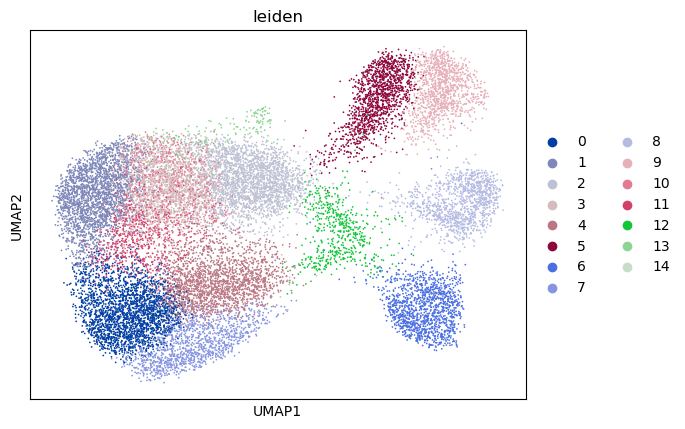

<Figure size 640x480 with 0 Axes>

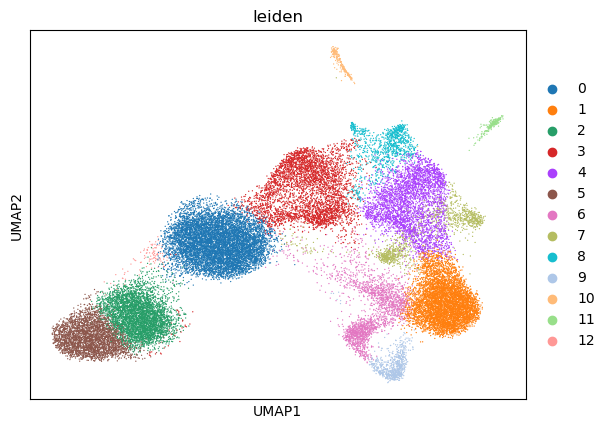

In [69]:
# Plot the UMAPs
plt.figure()
sc.pl.umap(VizgenLiver, color='leiden', show=False)
plt.show()

plt.figure()
sc.pl.umap(VizgenKidney, color='leiden', show=False)
plt.show()

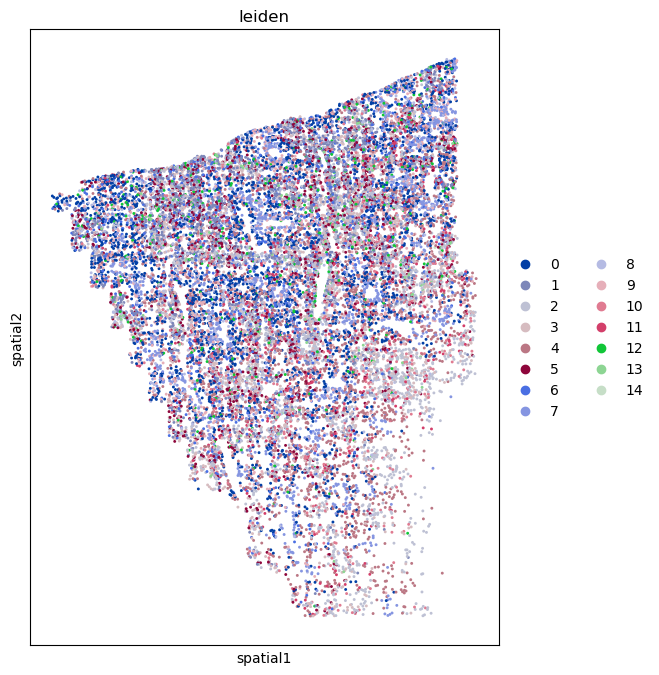

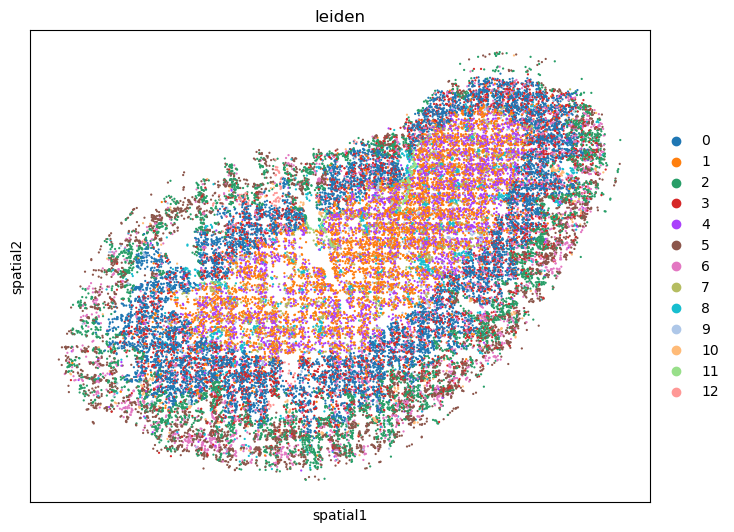

In [70]:
# Spatial plots
fig, ax = plt.subplots(figsize=(8,8))
sc.pl.spatial(VizgenLiver, color='leiden', spot_size=30, show=False, ax=ax)
plt.show()

fig, ax = plt.subplots(figsize=(8,8))
sc.pl.spatial(VizgenKidney, color='leiden', spot_size=30, show=False, ax=ax)
plt.show()

<Figure size 640x480 with 0 Axes>

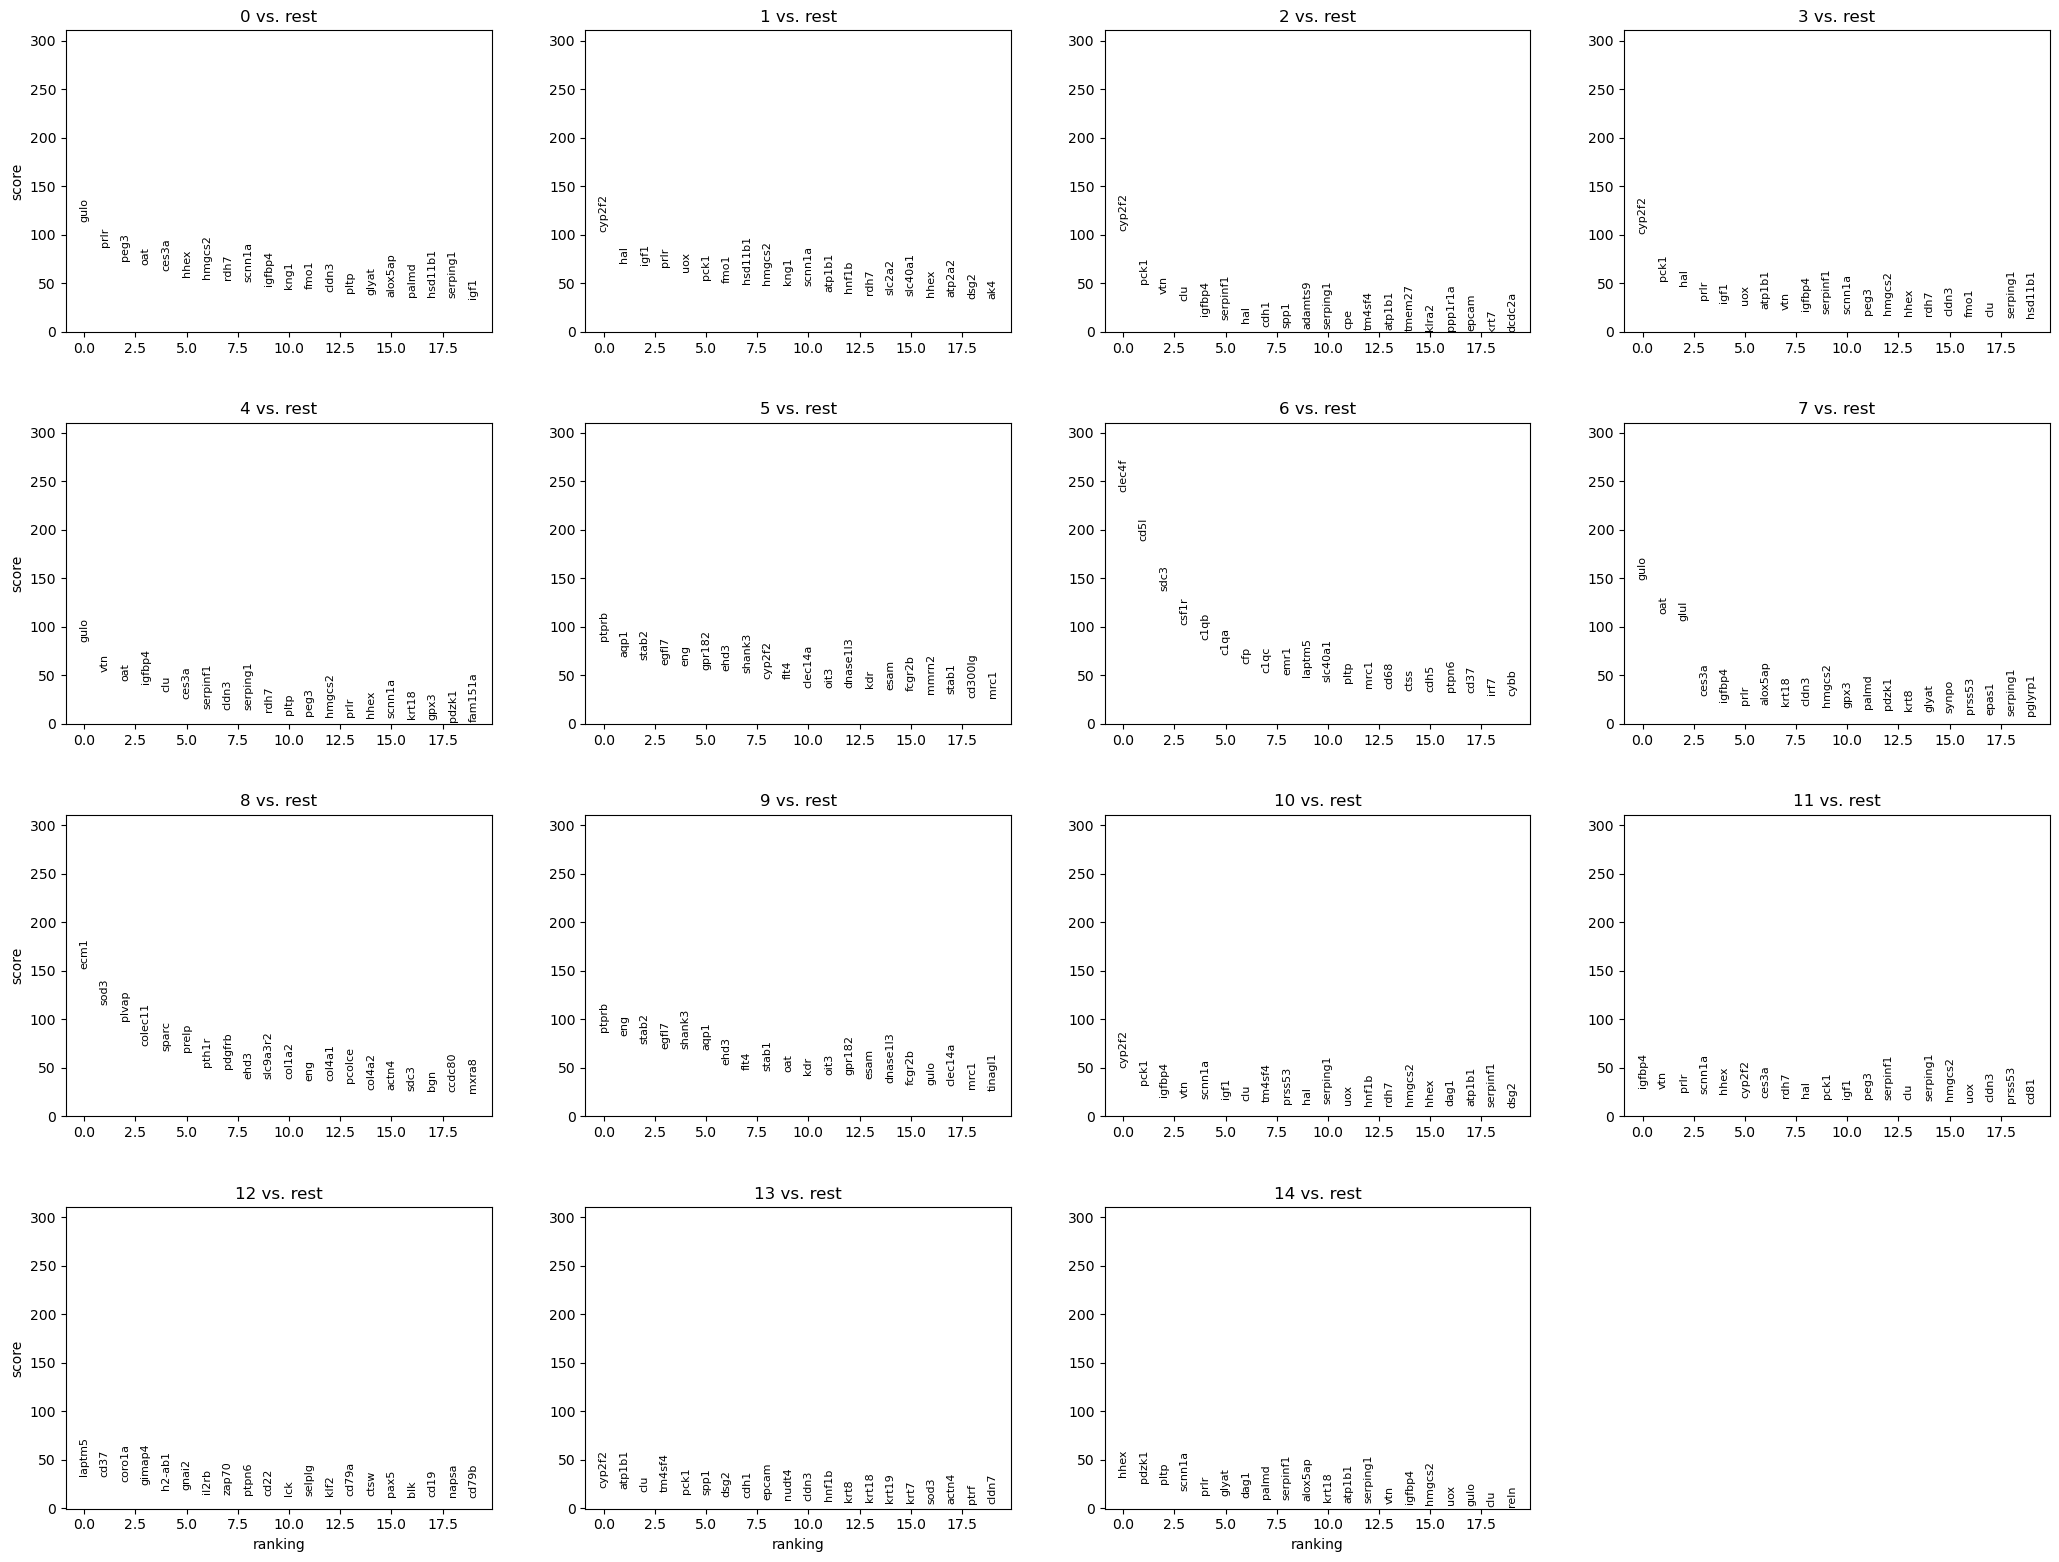

<Figure size 640x480 with 0 Axes>

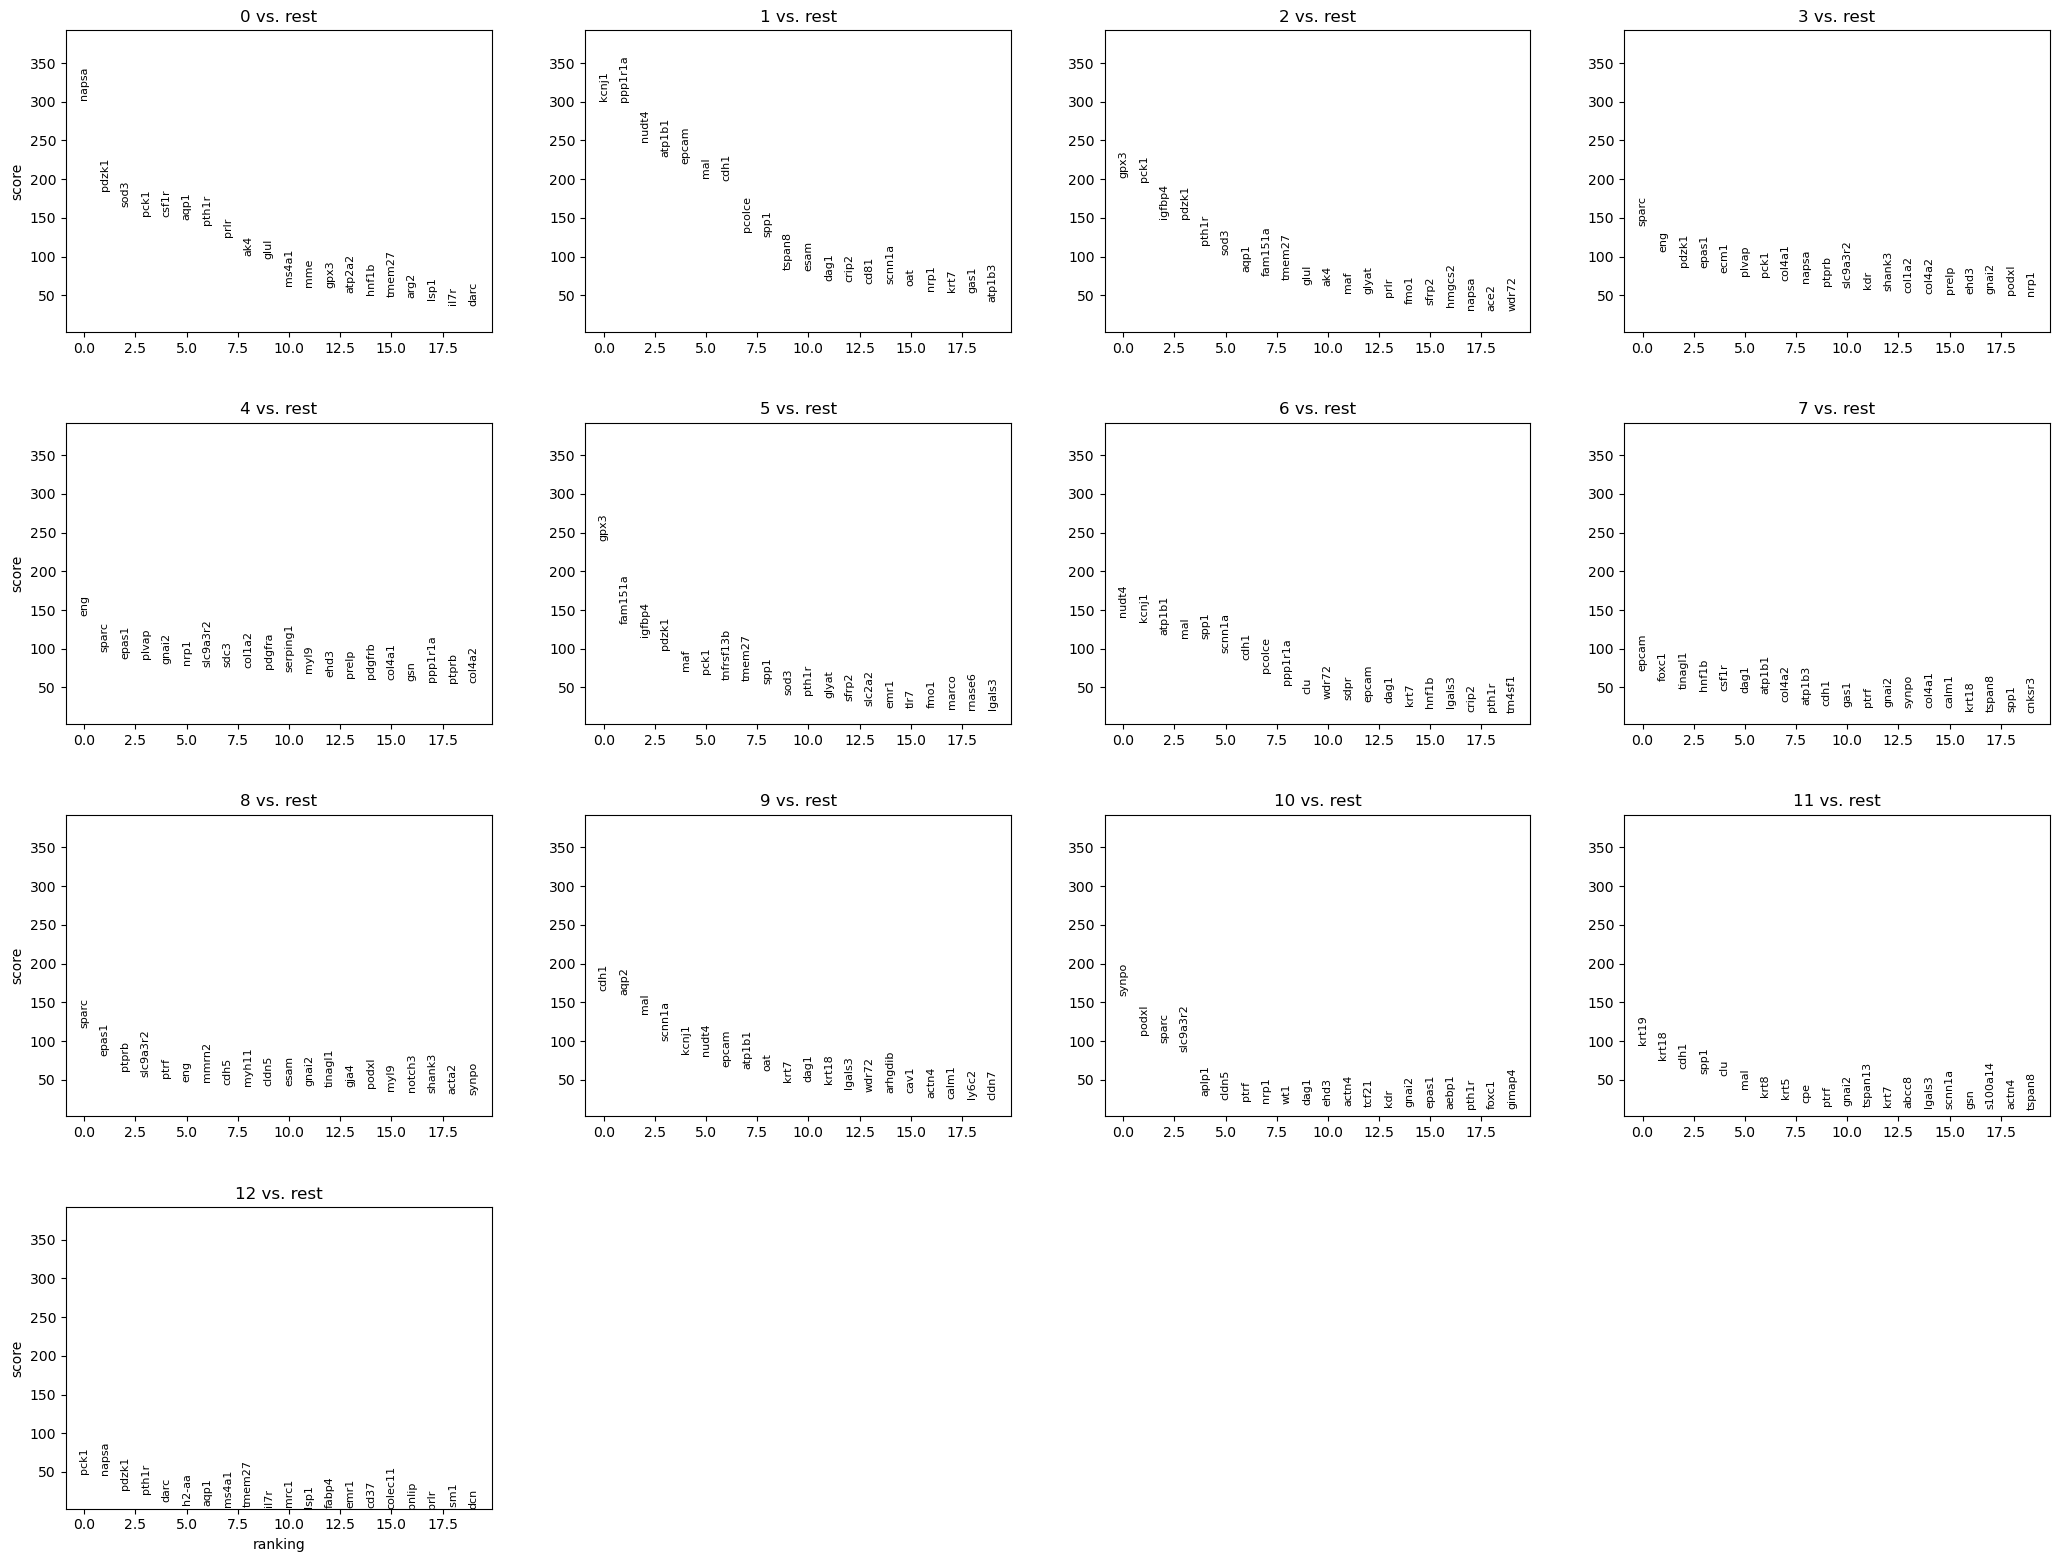

In [71]:
# Plot marker genes
sc.tl.rank_genes_groups(VizgenLiver, 'leiden')
sc.tl.rank_genes_groups(VizgenKidney, 'leiden')

plt.figure()
sc.pl.rank_genes_groups(VizgenLiver)
plt.show()

plt.figure()
sc.pl.rank_genes_groups(VizgenKidney)
plt.show()

In [72]:
# Get a dataframe for the marker genes
markers_liver = pd.DataFrame(VizgenLiver.uns['rank_genes_groups']['names'])
markers_kidney = pd.DataFrame(VizgenKidney.uns['rank_genes_groups']['names'])

In [93]:
'cd79a' in VizgenLiver.var.index

True

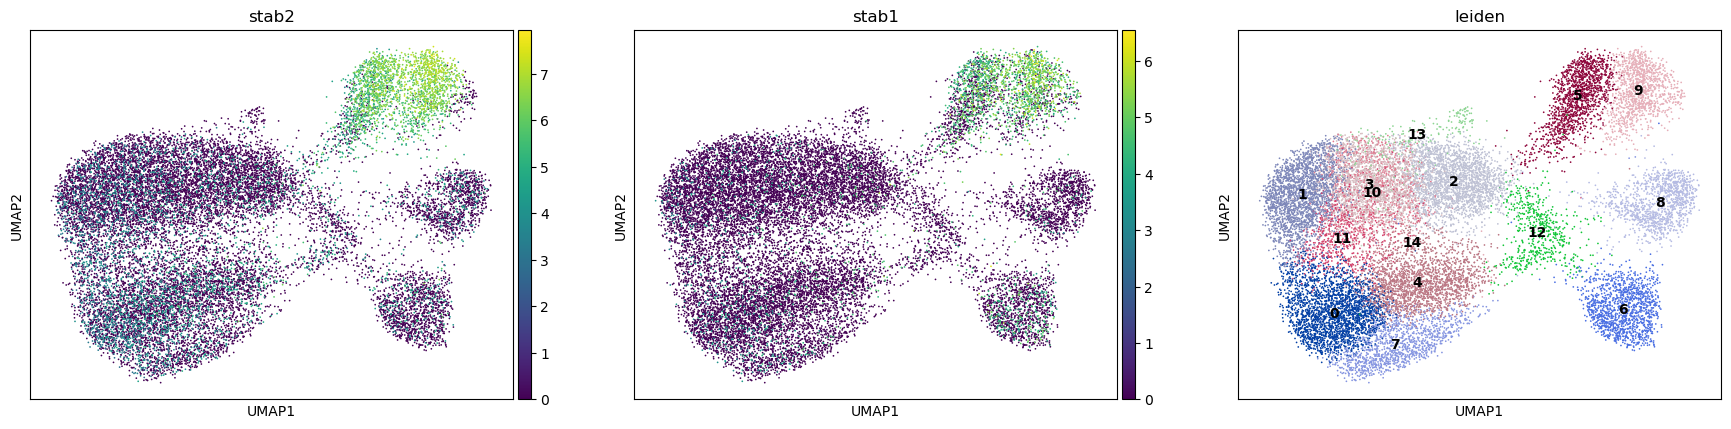

In [148]:
sc.pl.umap(VizgenLiver, color=['stab2','stab1','leiden'],legend_loc='on data')
plt.show()

In [73]:
# Liver cluster marker genes
markers_liver.head(10)

0        1         2         3         4       5       6        7  \
0    gulo   cyp2f2    cyp2f2    cyp2f2      gulo   ptprb  clec4f     gulo   
1    prlr      hal      pck1      pck1       vtn    aqp1    cd5l      oat   
2    peg3     igf1       vtn       hal       oat   stab2    sdc3     glul   
3     oat     prlr       clu      prlr    igfbp4   egfl7   csf1r    ces3a   
4   ces3a      uox    igfbp4      igf1       clu     eng    c1qb   igfbp4   
5    hhex     pck1  serpinf1       uox     ces3a  gpr182    c1qa     prlr   
6  hmgcs2     fmo1       hal    atp1b1  serpinf1    ehd3     cfp  alox5ap   
7    rdh7  hsd11b1      cdh1       vtn     cldn3  shank3    c1qc    krt18   
8  scnn1a   hmgcs2      spp1    igfbp4  serping1  cyp2f2    emr1    cldn3   
9  igfbp4     kng1   adamts9  serpinf1      rdh7    flt4  laptm5   hmgcs2   

          8       9      10      11      12      13        14  
0      ecm1   ptprb  cyp2f2  igfbp4  laptm5  cyp2f2      hhex  
1      sod3     eng    pck1     vtn    cd37  atp1b1     pdzk1  
2     plvap   stab2  igfbp4    prlr  coro1a     clu      pltp  
3   colec11   egfl7     vtn  scnn1a  gimap4  tm4sf4    scnn1a  
4     sparc  shank3  scnn1a    hhex  h2-ab1    pck1      prlr  
5     prelp    aqp1    igf1  cyp2f2   gnai2    spp1     glyat  
6     pth1r    ehd3     clu   ces3a   il2rb    dsg2      dag1  
7    pdgfrb    flt4  tm4sf4    rdh7   zap70    cdh1     palmd  
8      ehd3   stab1  prss53     hal   ptpn6   epcam  serpinf1  
9  slc9a3r2     oat     hal    pck1    cd22   nudt4   alox5ap

### Preliminary annotating:
- 0 = pericentral hep
- 1-3 = peripotal hep
- 4 = pericentral hep
- 5 = endothelial cell of hepatic sinusoid (aqp1, stab2, egfl7, ptprb, eng, flt4)
- 6 = Kupffer (clec4f)
- 7 = pericentral hep (gulo, oat)
- 8 = stellate cell (bgn, col1a2)
- 9 = endothelial
- 10 = periportal hep (cyp2f2)
- 11 = periportal hep (cyp2f2)
- 12 = recluster immune
- 13 = bile duct epithelial (epcam, krt17)
- 14 = unknown (remove? since only 3 cells)

Trying to set attribute `.uns` of view, copying.


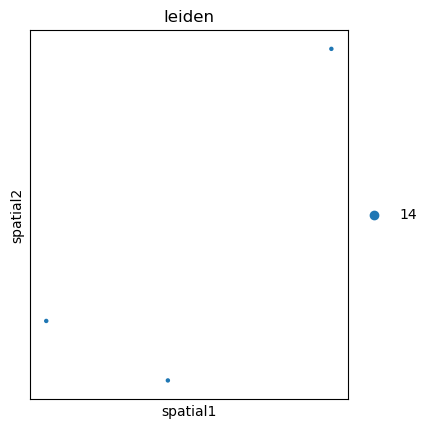

In [149]:
# Looking at cluster 14
sc.pl.spatial(VizgenLiver[VizgenLiver.obs['leiden'] == '14'], spot_size=30, color='leiden')
plt.show()

In [140]:
# Subcluster the endothelial cells
liver_endo = VizgenLiver[VizgenLiver.obs['leiden'].isin(['5','9'])].copy()

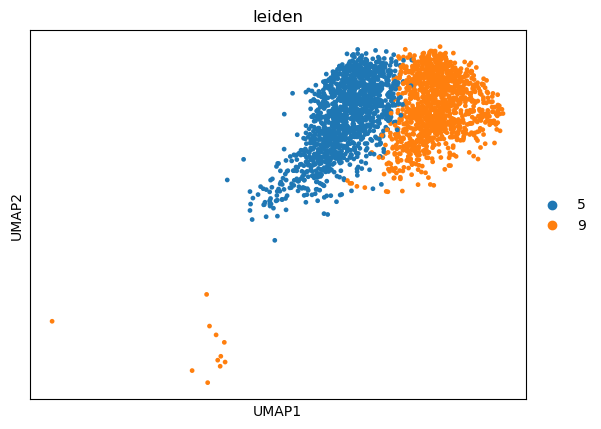

In [141]:
sc.pl.umap(liver_endo, color='leiden')
plt.show()

In [142]:
sc.tl.rank_genes_groups(liver_endo, 'leiden')
markers_liver_endo = pd.DataFrame(liver_endo.uns['rank_genes_groups']['names'])
markers_liver_endo.head(10)

5       9
0  cyp2f2     oat
1    pck1    gulo
2     hal    glul
3     uox   stab1
4     vtn    gpx3
5    ldb2     eng
6  atp1b1  shank3
7    cdh1    pltp
8    igf1   stab2
9  tm4sf4  col4a1

In [100]:
liver_map = {'0':'pc hep',
            '1':'pp hep',
            '2':'pp hep',
            '3':'pp hep',
            '4':'pc hep',
            '5':'endo',
            '6':'Kupffer',
            '7':'pc hep',
            '8':'stellate',
            '9':'endo',
            '10':'pp hep',
            '11':'prog',
            '12':'immune',
            '13':'pp hep',
            '14':'prog'
            }

VizgenLiver.obs['tentative_annot'] = VizgenLiver.obs['leiden'].map(liver_map)

In [101]:
VizgenLiver.obs['tentative_annot']

112379695218366873860549882516470536890     pc hep
12559338600922861474440709337722075912      pc hep
136424294865630680170129609768335163649    Kupffer
156821392620653799987123725353752218857     pp hep
16787838303036923982065738606329983132      pp hep
                                            ...   
56292141057567723530971261659166166639      pc hep
68121793071604327723635322621389293215      pp hep
71391041289612676296610859221534152213      pc hep
72333849092538517334192547046627660966      pp hep
89792734333654089648605667575363628015      pc hep
Name: tentative_annot, Length: 19698, dtype: object

/data01/jonathan.liu/miniconda3/envs/jupyter/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'tentative_annot' as categorical


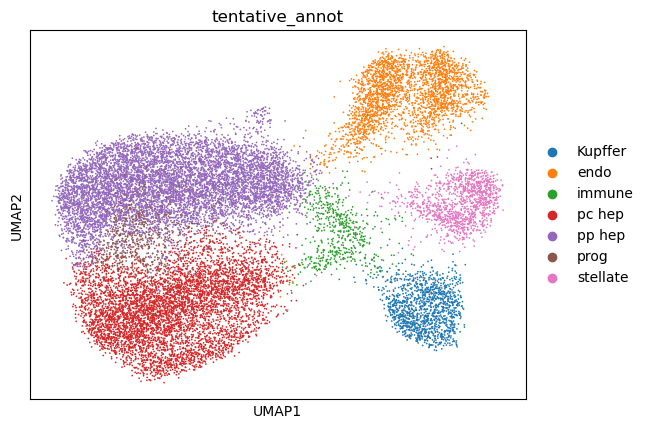

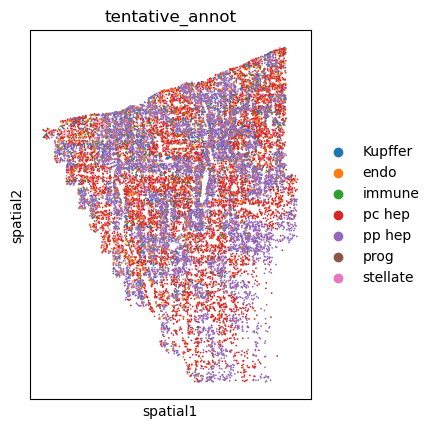

In [102]:
sc.pl.umap(VizgenLiver, color='tentative_annot')
plt.show()
sc.pl.spatial(VizgenLiver, color='tentative_annot', spot_size=30)
plt.show()

In [112]:
'col4a3' in VizgenKidney.var.index

False

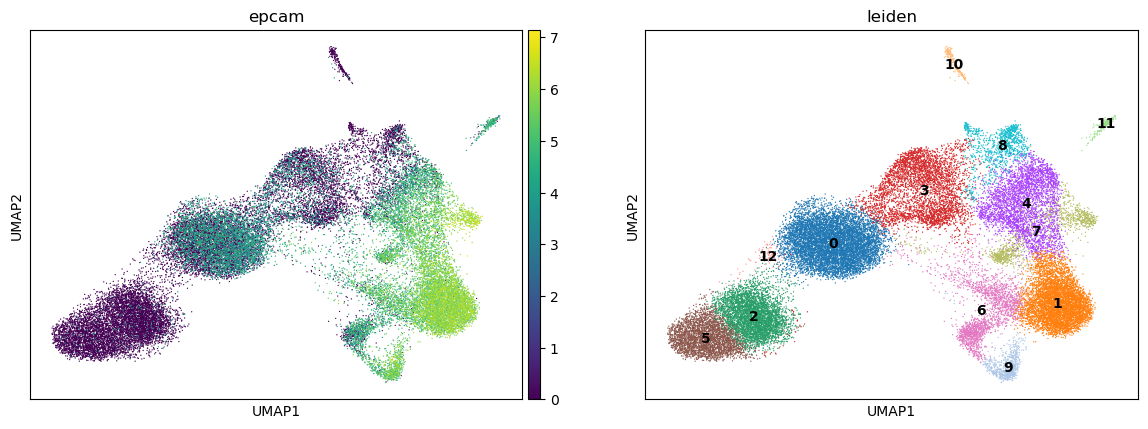

In [113]:
sc.pl.umap(VizgenKidney, color=['epcam','leiden'],legend_loc='on data')
plt.show()

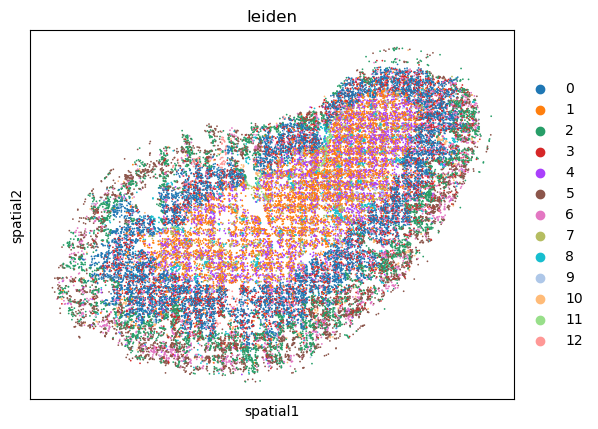

In [117]:
sc.pl.spatial(VizgenKidney, color='leiden', spot_size=30)
plt.show()

In [103]:
# Kidney cluster marker genes
markers_kidney.head(10)

0        1        2       3         4          5        6        7  \
0  napsa    kcnj1     gpx3   sparc       eng       gpx3    nudt4    epcam   
1  pdzk1  ppp1r1a     pck1     eng     sparc    fam151a    kcnj1    foxc1   
2   sod3    nudt4   igfbp4   pdzk1     epas1     igfbp4   atp1b1  tinagl1   
3   pck1   atp1b1    pdzk1   epas1     plvap      pdzk1      mal    hnf1b   
4  csf1r    epcam    pth1r    ecm1     gnai2        maf     spp1    csf1r   
5   aqp1      mal     sod3   plvap      nrp1       pck1   scnn1a     dag1   
6  pth1r     cdh1     aqp1    pck1  slc9a3r2  tnfrsf13b     cdh1   atp1b1   
7   prlr   pcolce  fam151a  col4a1      sdc3     tmem27   pcolce   col4a2   
8    ak4     spp1   tmem27   napsa    col1a2       spp1  ppp1r1a   atp1b3   
9   glul   tspan8     glul   ptprb    pdgfra       sod3      clu     cdh1   

          8       9        10     11      12  
0     sparc    cdh1     synpo  krt19    pck1  
1     epas1    aqp2     podxl  krt18   napsa  
2     ptprb     mal     sparc   cdh1   pdzk1  
3  slc9a3r2  scnn1a  slc9a3r2   spp1   pth1r  
4      ptrf   kcnj1     aplp1    clu    darc  
5       eng   nudt4     cldn5    mal   h2-aa  
6     mmrn2   epcam      ptrf   krt8    aqp1  
7      cdh5  atp1b1      nrp1   krt5   ms4a1  
8     myh11     oat       wt1    cpe  tmem27  
9     cldn5    krt7      dag1   ptrf    il7r

### Preliminary annotating:
- 0 = epithelial proximal tubule? (pck1)
- 1 = Loop of Henle (kcnj1, spp1, nudt4)
- 2 = epithelial proximal convoluted tubule (pck1, gpx3)
- 3 = pericyte/endo?
- 4 = Loop of Henle
- 5 = epithelial proximal convoluted tubule (pck1, gpx3)
- 6 = Loop of Henle
- 7 = Loop of Henle
- 8 = pericyte/endo (ptprb)
- 9 = collecting duct epithelial cell (Aqp2)
- 10 = podocyte (Synpo, Podxl)
- 11 = epithelial proximal tubule / brush cell (krt)
- 12 = epithelial proximal tubule

In [118]:
kidney_map = {'0':'EPT',
             '1':'LOH',
             '2':'EPT',
             '3':'peri/endo',
             '4':'LOH',
             '5':'EPT',
             '6':'LOH',
             '7':'LOH',
             '8':'peri/endo',
             '9':'CD-EC',
             '10':'pod',
             '11':'EPT',
             '12':'EPT'}

VizgenKidney.obs['tentative_annot'] = VizgenKidney.obs['leiden'].map(kidney_map)

/data01/jonathan.liu/miniconda3/envs/jupyter/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'tentative_annot' as categorical


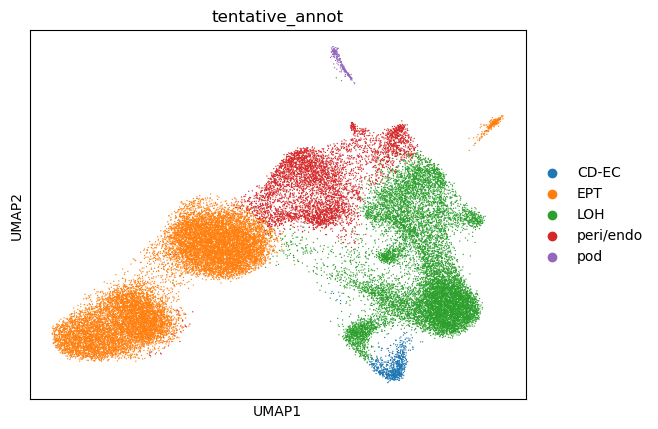

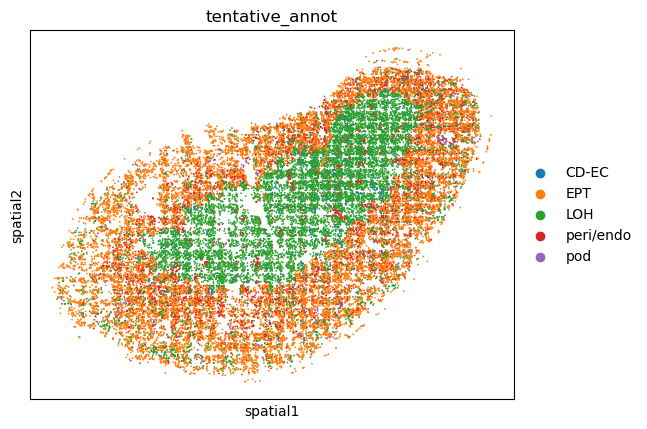

In [119]:
sc.pl.umap(VizgenKidney, color='tentative_annot')
plt.show()
sc.pl.spatial(VizgenKidney, color='tentative_annot', spot_size=30)
plt.show()

In [41]:
# Save the results
saveDir = '../../../results/'

# Save the h5ad files
VizgenLiver.write(saveDir + 'MERFISH_liver_object.h5ad')
VizgenKidney.write(saveDir + 'MERFISH_kidney_object.h5ad')

print('Results saved.')

Results saved.
